In [265]:
# %load_ext iminizinc
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
# import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6
import seaborn as sns
from scipy.signal import find_peaks, peak_widths
import pickle
from scipy.signal import argrelextrema, argrelmax, argrelmin


import sys, os
sys.path.append(os.path.abspath('..'))
from research.pkg.lib import *


# import mplfinance as mpf
%matplotlib inline

plt.rcParams['lines.linewidth'] = 1 

mpl.rcParams.update({'font.size': 10, 'lines.linewidth': 1, 'figure.dpi': 300})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [214]:
from minizinc import Instance, Model, Solver, Status as mzStatus
import nest_asyncio
nest_asyncio.apply()

In [166]:

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_blobs
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap

In [210]:

def call_mzn_model(model_name,model_params):
    with open(f'pars-{model_name}.dzn.json', 'w+') as f: f.write(json.dumps(model_params, indent=2))

    # print('Model params:', model_params)

    mzn_model = Model(f'{model_name}.mzn')
    gecode = Solver.lookup("gecode")
    instance = Instance(gecode, mzn_model)

    for k,v in model_params.items(): instance[k] = v
    result = instance.solve()

    return result


In [71]:

def plot_candles(wdf, ax=None, kwargs={}):
    if ax is None:
        fig, ax = plt.subplots(**kwargs)

    up, down = wdf[wdf.close >= wdf.open], wdf[wdf.close < wdf.open]
    col1,col2 = 'green','red'
    width, width2 = 2, .2
    # Plotting up prices of the stock
    ax.bar(up.index, up.close-up.open, width, bottom=up.open, color=col1)
    ax.bar(up.index, up.high-up.close, width2, bottom=up.close, color=col1)
    ax.bar(up.index, up.low-up.open, width2, bottom=up.open, color=col1)
    # Plotting down prices of the stock
    ax.bar(down.index, down.close-down.open, width, bottom=down.open, color=col2)
    ax.bar(down.index, down.high-down.open, width2, bottom=down.open, color=col2)
    ax.bar(down.index, down.low-down.close, width2, bottom=down.close, color=col2)    
    plt.xticks(rotation=30, ha='right')
    return ax

In [3]:
pair = 'BTC_USDT'
timeframe = '4h'

exchange = 'binance'
odf = pd.read_json(f'../freq-user-data/data/{exchange}/{pair}-{timeframe}.json'
# exchange = 'kucoin'
# odf = pd.read_json(f'../../freq-user-data/data/{exchange}/futures/{pair}-{timeframe}-futures.json'
).dropna().set_axis(['timestamp', 'open', 'high', 'low', 'close', 'volume'], axis=1
).assign(dtime=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=False)
).set_index('dtime').sort_index()

print(odf.shape)
odf.head(4)

(12676, 6)


,timestamp,open,high,low,close,volume
dtime,,,,,,
2017-08-17 04:00:00,1502942400000,4261.48,4349.99,4261.32,4349.99,82.088865
2017-08-17 08:00:00,1502956800000,4333.32,4485.39,4333.32,4427.30,63.619882
2017-08-17 12:00:00,1502971200000,4436.06,4485.39,4333.42,4352.34,174.562001
2017-08-17 16:00:00,1502985600000,4352.33,4354.84,4200.74,4325.23,225.109716


In [253]:
odf['boL'] = odf[['open', 'close']].min(axis=1)
odf['boH'] = odf[['open', 'close']].max(axis=1)
odf['cadir'] = 1 - 2 *(odf.close < odf.open)
odf['dirF1'] = odf.cadir.shift(-1).ffill().astype(int)
###
odf['cadir'] = 1 - 2*(odf.close < odf.open).astype(int)
# wdf
mzn_res = call_mzn_model('last-such', {'markers': odf.cadir.values.tolist()})
odf['n_prev'] = mzn_res['prev']

odf['f_6_close_max'] = odf.close.rolling(6).max().shift(-6)
# roll18 = odf.rolling(18)
# odf['l_18_std']

###
odf.head(5)


,timestamp,open,high,low,close,volume,boL,boH,cadir,dirF1,n_prev,n_next,f_6_close_max
dtime,,,,,,,,,,,,,
2017-08-17 04:00:00,1502942400000,4261.48,4349.99,4261.32,4349.99,82.088865,4261.48,4349.99,1,1,0,1,4427.30
2017-08-17 08:00:00,1502956800000,4333.32,4485.39,4333.32,4427.30,63.619882,4333.32,4427.30,1,-1,1,0,4352.34
2017-08-17 12:00:00,1502971200000,4436.06,4485.39,4333.42,4352.34,174.562001,4352.34,4436.06,-1,-1,0,-2,4340.31
2017-08-17 16:00:00,1502985600000,4352.33,4354.84,4200.74,4325.23,225.109716,4325.23,4352.33,-1,-1,-1,-1,4340.31
2017-08-17 20:00:00,1503000000000,4307.56,4369.69,4258.56,4285.08,249.769913,4285.08,4307.56,-1,1,-2,0,4340.31


In [141]:

laRoll = wdf.rolling(window=3)
(laRoll.boL.std() / wdf.close).describe()

count    12674.000000
mean         0.007794
std          0.009416
min          0.000001
25%          0.001926
50%          0.004708
75%          0.010269
max          0.150481
dtype: float64

In [229]:
def add_indicators(wdf, lag, xOrd):
    ###
    laRoll = wdf.rolling(window=lag)
    wdf[f'laMean'] = laRoll.boL.mean()#.bfill()
    wdf[f'laMin'] = laRoll.boL.min()#.bfill()
    wdf[f'laMax'] = laRoll.boL.max()#.bfill()
    wdf[f'laStd'] = laRoll.boL.std() 
    wdf[f'laZScore'] = (wdf.close - wdf.laMean) / wdf.laStd #.bfill()

    laRoll = wdf.rolling(window=lag)
    wdf[f'wd2laMeanP'] = wdf.low.divide(wdf.laMean).apply(np.log) * (wdf.laMean > wdf.low)
    wdf[f'wdSum'] = laRoll.wd2laMeanP.sum()
    wdf[f'wdMin'] = laRoll.wd2laMeanP.min()

    wdf[f'l_18_min'] = wdf.close.rolling(18).min()
    wdf[f'l_18_max'] = wdf.close.rolling(18).min()
    ###
    # for local maxima
    iUps = argrelextrema(wdf.close.values, np.greater, order=xOrd)
    iDns = argrelextrema(wdf.close.values, np.less, order=xOrd)
    ixUps = wdf.index[iUps]
    ixDns = wdf.index[iDns]
    ###
    return wdf


In [255]:
# import logging

# logging.basicConfig(filename="minizinc-python.log", level=logging.DEBUG)
wdf = None
sig = None
def printer(ws, xOrd, laZScore, par_wick):
    global wdf, sig
    wstart = ws * wlen
    wend = wstart + wlen
    wdf = odf.iloc[wstart:wend].copy()

    wdf = add_indicators(wdf, lag=4, xOrd=xOrd)
    sig = ((wdf.laZScore < laZScore) & (wdf.cadir == -1))

    # isig = wdf[sig].index
    
    ###
    fig = plt.figure(figsize=(15,5))
    # fig, (ax1,ax2) = plt.subplots(2,1, height_ratios=[2,1], sharex=True)
    plt.tight_layout()
    ax1,ax2 = fig.subplots(2,1, height_ratios=[2,1], sharex=True)
    wdf.close.plot(ax=ax1, lw=0.5)
    for i in wdf.index[sig]: 
        for ax in [ax1]:
            ax.axvline(i, lw=2, alpha=0.2)
    wdf.wdSum.plot(ax=ax2, secondary_y=True, legend='wdSum')
    wdf.wdMin.plot(ax=ax2, legend=True)
    wdf.laZScore.plot(ax=ax1, secondary_y=True)
    # ax1.set_label(True)
    # ax1.scatter(ixUps, wdf.close[ixUps], c='r', alpha=0.3, s=50)
    # ax1.scatter(ixDns, wdf.close[ixDns], c='g', alpha=0.3, s=50)
    # ax2.plot(wdf.index,wdf.wdSum, c='b')
    plot_candles(wdf,ax=ax1)
    
    # ax1.scatter(ix_dpeaks, wdf.loc[ix_dpeaks].close, c='g', alpha=0.3, s=100)
wlen = 2000
interact(printer, 
         ws=IntSlider(min=0, max=odf.shape[0] // wlen, step=1, value=50, description='wn'), 
         xOrd=IntSlider(min=1,max=15,value=6, description='XOrd'),
         laZScore=FloatText(min=0.,max=0.10,step=0.001, value=0.0005, description='laZScore'), 
         par_wick=FloatText(min=0.,max=0.05,step=0.001, description='wick'))

interactive(children=(IntSlider(value=6, description='wn', max=6), IntSlider(value=6, description='XOrd', max=…

<function __main__.printer(ws, xOrd, laZScore, par_wick)>

In [247]:
# wdf.index[sig]
# laRoll

### Naive Bayes

In [159]:

# wdf

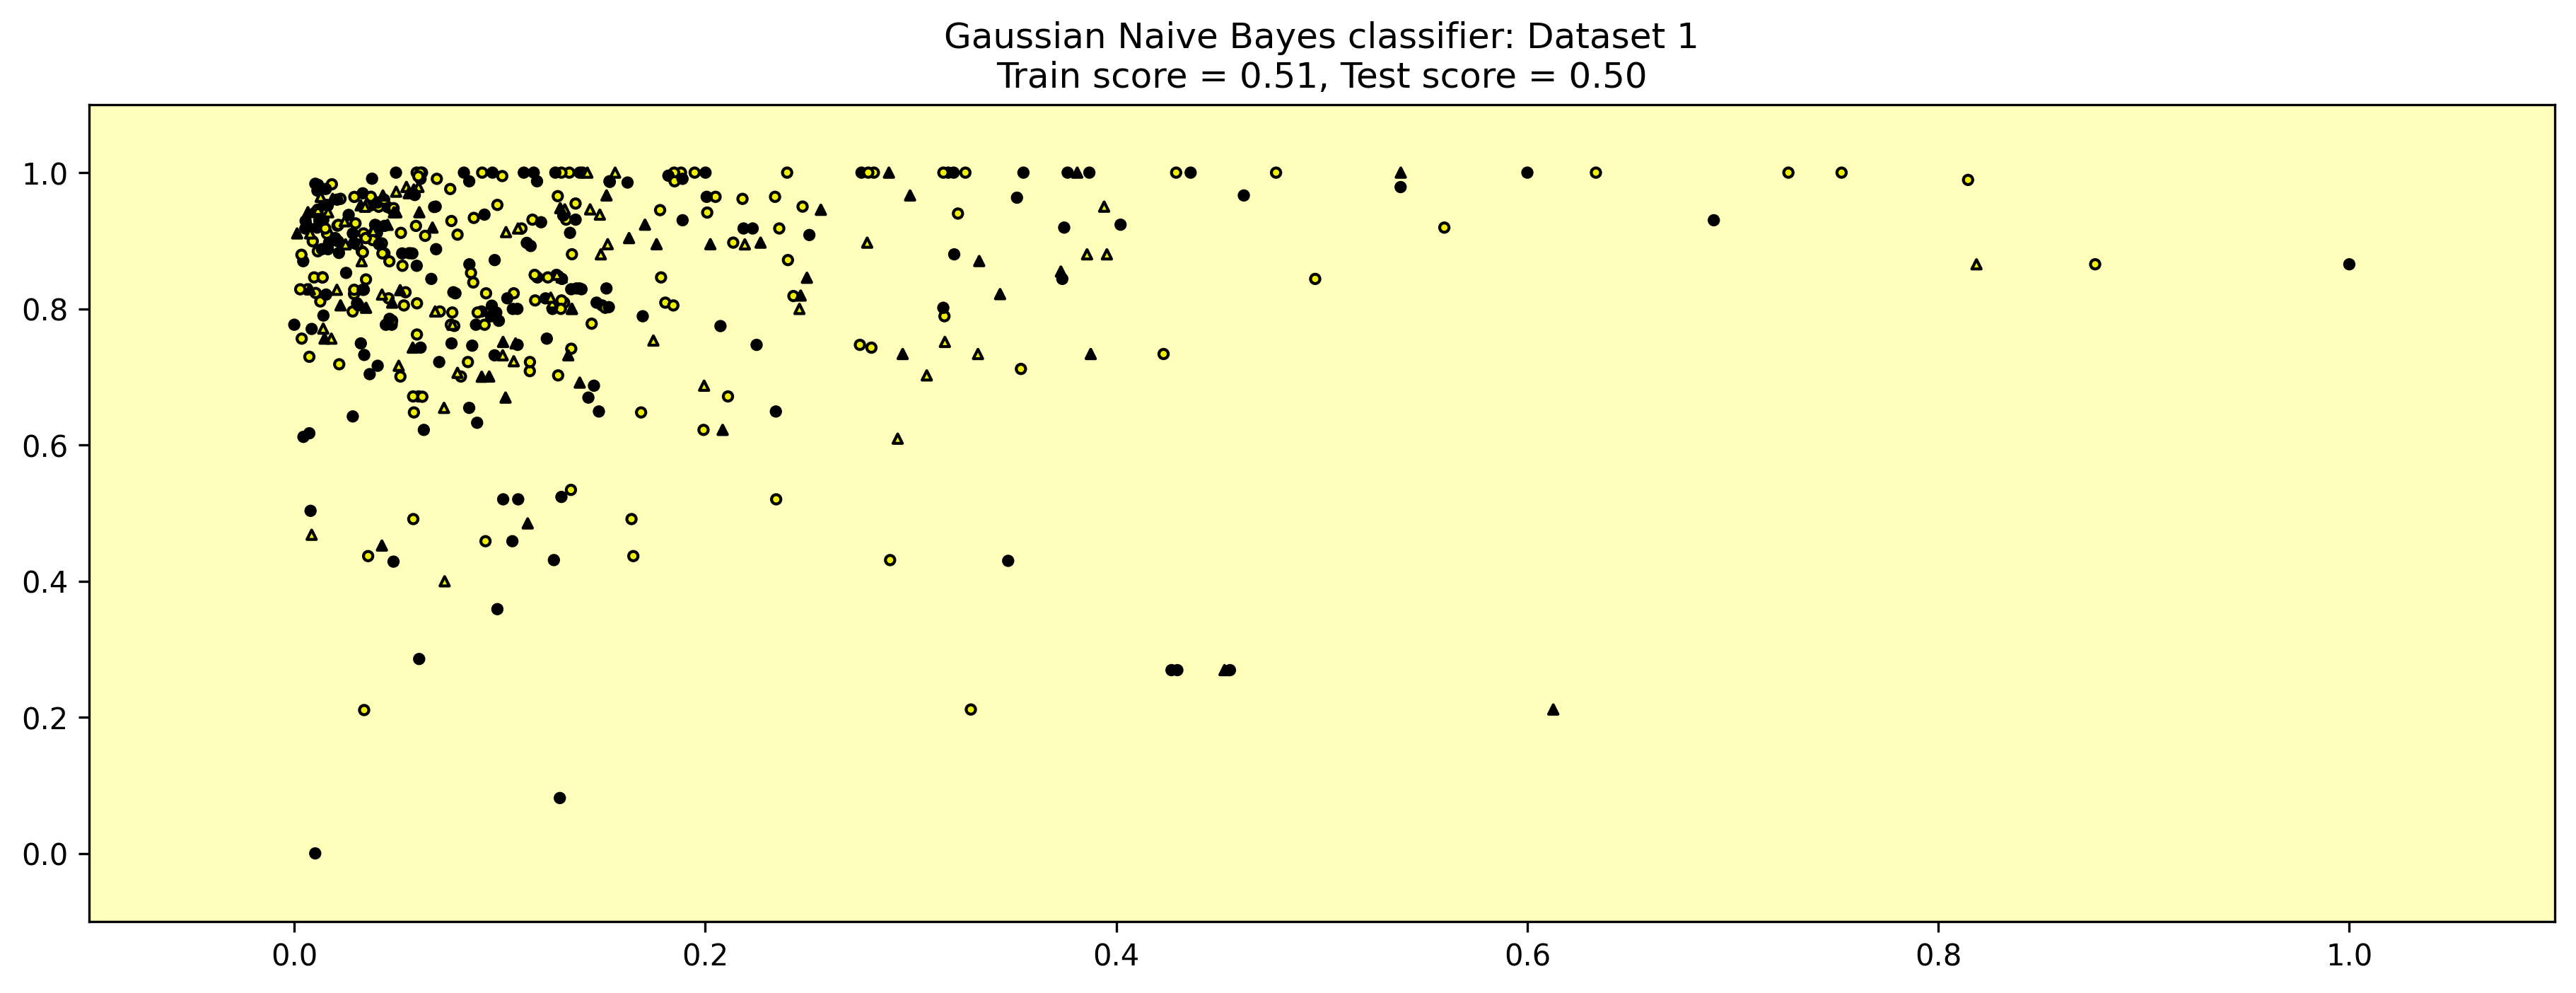

In [186]:
from sklearn.naive_bayes import GaussianNB
from adspy_shared_utilities import plot_class_regions_for_classifier

adf = wdf[wdf.laZScore >= 0.0005 ].dropna()
X_wdf = adf[['laStd','wdMin']].values
y_wdf = adf.dirF1.values

X_train, X_test, y_train, y_test = train_test_split(X_wdf, y_wdf, random_state=0)

scaler = MinMaxScaler()

X_trainS = scaler.fit_transform(X_train)
X_testS = scaler.transform(X_test)

nbclf = GaussianNB().fit(X_train, y_train)
plot_class_regions_for_classifier(nbclf, X_trainS, y_train, X_testS, y_test,
                                 'Gaussian Naive Bayes classifier: Dataset 1', gkwargs={'figsize':(15,5)})

### Gradient-Boosted Decision Tree

In [206]:
from sklearn.ensemble import GradientBoostingClassifier


adf = wdf[wdf.laZScore >= 0.0005 ].dropna()
X_wdf = adf[['laStd', 'wdSum']].values
y_wdf = adf.dirF1.values

X_train, X_test, y_train, y_test = train_test_split(X_wdf, y_wdf, random_state=0)

# clf = GradientBoostingClassifier(random_state = 0)
# clf.fit(X_train, y_train)

# print('(learning_rate=0.1, max_depth=3)')
# print('Accuracy of GBDT classifier on training set: {:.2f}'
#      .format(clf.score(X_train, y_train)))
# print('Accuracy of GBDT classifier on test set: {:.2f}\n'
#      .format(clf.score(X_test, y_test)))

clf = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 5, random_state = 0)
clf.fit(X_train, y_train)

print('(learning_rate=0.01, max_depth=2)')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

(learning_rate=0.01, max_depth=2)
Accuracy of GBDT classifier on training set: 1.00
Accuracy of GBDT classifier on test set: 0.45


### Neural Nets Classifier

In [254]:
from sklearn.neural_network import MLPClassifier
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

wdf = wdf.dropna()
X_wdf = wdf[['laStd','wdMin', 'n_prev']].values
y_wdf = wdf.dirF1.values

X_train, X_test, y_train, y_test = train_test_split(X_wdf, y_wdf, random_state=0)

scaler = MinMaxScaler()

X_trainS = scaler.fit_transform(X_train)
X_testS = scaler.transform(X_test)

fig, subaxes = plt.subplots(3, 1, figsize=(15,6))

for units, axis in zip([10, 100], subaxes):
    nnclf = MLPClassifier(hidden_layer_sizes = [units]* 2, solver='lbfgs',
                         random_state = 0).fit(X_trainS, y_train)
    
    title = 'Dataset 1: Neural net classifier, 1 layer, {} units'.format(units)
    
    # plot_class_regions_for_classifier_subplot(nnclf, X_trainS, y_train,
                                            #  X_testS, y_test, title, axis)
    plt.tight_layout()

AttributeError: 'DataFrame' object has no attribute 'f_6_close_max'

In [264]:
from sklearn.neural_network import MLPClassifier
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

wdf = wdf.dropna()
X_wdf = wdf[['laStd','wdMin', 'n_prev','l_18_min']].values
y_wdf = wdf.dirF1.values

X_train, X_test, y_train, y_test = train_test_split(X_wdf, y_wdf, random_state=0)

scaler = MinMaxScaler()

X_trainS = scaler.fit_transform(X_train)
X_testS = scaler.transform(X_test)


for layers,units in [(4,15), (3,16), (3,10)]:
    clf = MLPClassifier(hidden_layer_sizes = [units]* layers, solver='lbfgs',
                         random_state = 0).fit(X_trainS, y_train)
    
    train_score = clf.score(X_trainS, y_train)
    test_score  = clf.score(X_testS, y_test)
    print('================================================================')
    print(f'Neural net classifier, {layers} layer, {units} units')
    print(f"Train score = {train_score:.2f}, Test score = {test_score:.2f}")
    
    # plot_class_regions_for_classifier_subplot(nnclf, X_trainS, y_train,
                                            #  X_testS, y_test, title, axis)
    # plt.tight_layout()

/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Neural net classifier, 4 layer, 15 units
Train score = 0.57, Test score = 0.53


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Neural net classifier, 3 layer, 16 units
Train score = 0.55, Test score = 0.51
Neural net classifier, 3 layer, 10 units
Train score = 0.54, Test score = 0.55


/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
